In [1]:
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from torch import Tensor
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
from torchtext.legacy.data import Field, TabularDataset, BucketIterator
import matplotlib.pyplot as plt

# dataset folder
source_folder = "solo_classification_REMI_dataset_unbalanced"
# where it saves the weights
destination_folder = "solo_classification_transformer_REMI_weights_unaugmented_200epochs_fulltransformer"

In [2]:
if torch.cuda.is_available():  
    dev = "cuda:0" 
else:  
    dev = "cpu" 
print(dev)
device = torch.device(dev)
print(device)

cuda:0
cuda:0


In [3]:
# Fields

label_field = Field(sequential=False, use_vocab=False, batch_first=True, dtype=torch.float)
text_field = Field(tokenize=None, lower=True, include_lengths=True, batch_first=True)
fields = [('labels', label_field), ('notes', text_field)]

# TabularDataset

train, valid, test = TabularDataset.splits(path=source_folder, train='train.csv', validation='val.csv', test='test.csv',
                                           format='CSV', fields=fields, skip_header=True)

# Iterators

train_iter = BucketIterator(train, batch_size=32, sort_key=lambda x: len(x.notes),
                            device=device, sort=False, sort_within_batch=True)
valid_iter = BucketIterator(valid, batch_size=32, sort_key=lambda x: len(x.notes),
                            device=device, sort=False, sort_within_batch=True)
test_iter = BucketIterator(test, batch_size=32, sort_key=lambda x: len(x.notes),
                            device=device, sort=False, sort_within_batch=True)

# Vocabulary

text_field.build_vocab(train, min_freq=1)

In [4]:
ntokens = len(text_field.vocab)
emsize = 200
d_hid = 64
nlayers = 2 
nhead = 8
dropout = 0.6

In [5]:
for (labels, (notes, notes_len)), _ in (train_iter):
    print(notes)

tensor([[  4,   7,  30,  ...,   8,  23,  89],
        [  4,   7,  30,  ...,  15,  29,   5],
        [  4,   7,  30,  ...,  53,  27, 116],
        ...,
        [  4,   7,  58,  ...,   1,   1,   1],
        [  4,   7,  30,  ...,   1,   1,   1],
        [  4,   7,  58,  ...,   1,   1,   1]], device='cuda:0')
tensor([[  4,   7,  30,  ...,  24,  38, 127],
        [  4,   7,  30,  ...,   9,  39,   5],
        [  4,   7,  30,  ...,  10,  55,   2],
        ...,
        [  4,   7,  30,  ...,  56,   6,   1],
        [  4,   7,  30,  ...,  43,  61,   1],
        [  4,   7,  30,  ...,  38, 118,   1]], device='cuda:0')
tensor([[ 4,  7, 30,  ...,  9, 23,  5],
        [ 4,  7, 30,  ..., 10, 70,  2],
        [ 4,  7, 30,  ..., 51, 27,  6],
        ...,
        [ 4,  7, 30,  ..., 78,  1,  1],
        [ 4,  7, 30,  ..., 89,  1,  1],
        [ 4,  7, 30,  ..., 72,  1,  1]], device='cuda:0')
tensor([[ 4,  7, 30,  ..., 22, 40,  5],
        [ 4,  7, 30,  ...,  8, 29, 89],
        [ 4,  7, 30,  ..., 14, 92, 

In [6]:
import os
#os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [19]:
import math
from typing import Tuple

import torch
from torch import nn, Tensor
import torch.nn.functional as F
from torch.nn import TransformerEncoder, TransformerEncoderLayer, Transformer
from torch.utils.data import dataset

#https://github.com/aladdinpersson/Machine-Learning-Collection/blob/master/ML/Pytorch/more_advanced/seq2seq_transformer/seq2seq_transformer.py
class Transformer(nn.Module):
    def __init__(
        self,
        embedding_size,
        src_vocab_size,
        trg_vocab_size,
        src_pad_idx,
        num_heads,
        num_encoder_layers,
        num_decoder_layers,
        forward_expansion,
        dropout,
        max_len,
        device,
    ):
        super(Transformer, self).__init__()
        self.src_word_embedding = nn.Embedding(src_vocab_size, embedding_size)
        self.src_position_embedding = nn.Embedding(max_len, embedding_size)
        self.trg_word_embedding = nn.Embedding(trg_vocab_size, embedding_size)
        self.trg_position_embedding = nn.Embedding(max_len, embedding_size)

        self.device = device
        self.transformer = nn.Transformer(
            embedding_size,
            num_heads,
            num_encoder_layers,
            num_decoder_layers,
            forward_expansion,
            dropout,
        )
        self.fc_out = nn.Linear(embedding_size, trg_vocab_size)
        self.dropout = nn.Dropout(dropout)
        self.src_pad_idx = src_pad_idx

    def make_src_mask(self, src):
        src_mask = src.transpose(0, 1) == self.src_pad_idx

        # (N, src_len)
        return src_mask.to(self.device)

    def forward(self, src, trg):
        src_seq_length, N = src.shape
        trg_seq_length, N = trg.shape

        src_positions = (
            torch.arange(0, src_seq_length)
            .unsqueeze(1)
            .expand(src_seq_length, N)
            .to(self.device)
        )

        trg_positions = (
            torch.arange(0, trg_seq_length)
            .unsqueeze(1)
            .expand(trg_seq_length, N)
            .to(self.device)
        )

        embed_src = self.dropout(
            (self.src_word_embedding(src) + self.src_position_embedding(src_positions))
        )
        embed_trg = self.dropout(
            (self.trg_word_embedding(trg) + self.trg_position_embedding(trg_positions))
        )

        src_padding_mask = self.make_src_mask(src)
        trg_mask = self.transformer.generate_square_subsequent_mask(trg_seq_length).to(
            self.device
        )

        out = self.transformer(
            embed_src,
            embed_trg,
            src_key_padding_mask=src_padding_mask,
            tgt_mask=trg_mask,
        )
        out = self.fc_out(out)
        return out


In [20]:
# Save and Load Functions https://towardsdatascience.com/lstm-text-classification-using-pytorch-2c6c657f8fc0

def save_checkpoint(save_path, model, optimizer, valid_loss):

    if save_path == None:
        return
    
    state_dict = {'model_state_dict': model.state_dict(),
                  'optimizer_state_dict': optimizer.state_dict(),
                  'valid_loss': valid_loss}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')


def load_checkpoint(load_path, model, optimizer):

    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    model.load_state_dict(state_dict['model_state_dict'])
    optimizer.load_state_dict(state_dict['optimizer_state_dict'])
    
    return state_dict['valid_loss']


def save_metrics(save_path, train_loss_list, valid_loss_list, global_steps_list):

    if save_path == None:
        return
    
    state_dict = {'train_loss_list': train_loss_list,
                  'valid_loss_list': valid_loss_list,
                  'global_steps_list': global_steps_list}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')


def load_metrics(load_path):

    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    return state_dict['train_loss_list'], state_dict['valid_loss_list'], state_dict['global_steps_list']


In [24]:
# Training Function

def train(model,
          optimizer,
          criterion = nn.CrossEntropyLoss(),
          train_loader = train_iter,
          valid_loader = valid_iter,
          num_epochs = 10,
          eval_every = len(train_iter),
          file_path = destination_folder,
          best_valid_loss = float("Inf")):
    
    # initialize running values
    running_loss = 0.0
    valid_running_loss = 0.0
    global_step = 0
    train_loss_list = []
    valid_loss_list = []
    global_steps_list = []

    # training loop
    model.train()
    for epoch in range(num_epochs):
        total = 0
        total_correct = 0
        for (labels, (notes, notes_len)), _ in (train_loader):   
            labels = labels.to(device)
            notes = notes.to(device)
            notes_len = notes_len.cpu()
            output = model(notes.long(), labels.long())
            loss = criterion(output, labels.long())
            #loss = criterion(output.view(-1,1),labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            labels_max = labels.detach().cpu()
            output_max = np.argmax((output.detach().cpu()),axis=1)
            for i in range(len(labels_max)):
                total+=1
                if labels_max[i] ==  output_max[i]:
                    total_correct += 1
            accuracy = accuracy_score(labels_max, output_max)
            
            # update running values
            running_loss += loss.item()
            global_step += 1

            # evaluation step
            if global_step % eval_every == 0:
                model.eval()
                with torch.no_grad():                    
                  # validation loop
                    for (labels, (notes, notes_len)), _ in (valid_loader):        
                        labels = labels.to(device)
                        notes = notes.to(device)
                        notes_len = notes_len.cpu()
                        output = model(notes.long(), labels.long())
                        loss = criterion(output, labels.long())
                        valid_running_loss += loss.item()

                # evaluation
                average_train_loss = running_loss / eval_every
                average_valid_loss = valid_running_loss / len(valid_loader)
                train_loss_list.append(average_train_loss)
                valid_loss_list.append(average_valid_loss)
                global_steps_list.append(global_step)

                # resetting running values
                running_loss = 0.0                
                valid_running_loss = 0.0
                model.train()

                # print progress
                print('Epoch [{}/{}], Step [{}/{}], Train Loss: {:.4f}, Valid Loss: {:.4f}'
                      .format(epoch+1, num_epochs, global_step, num_epochs*len(train_loader),
                              average_train_loss, average_valid_loss))
                
                # checkpoint
                if best_valid_loss > average_valid_loss:
                    best_valid_loss = average_valid_loss
                    save_checkpoint(file_path + '/model.pt', model, optimizer, best_valid_loss)
                    save_metrics(file_path + '/metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
        print("Epoch Accuracy: {}".format(total_correct/total))
    save_metrics(file_path + '/metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    print('Finished Training!')
    
src_vocab_size = len(text_field.vocab)
embedding_size = 200
num_heads = 8
num_encoder_layers = 2
num_decoder_layers = 2
dropout = 0.60
max_len = 1200
forward_expansion = 4


model = Transformer(
    embedding_size,
    src_vocab_size,
    1,
    None,
    num_heads,
    num_encoder_layers,
    num_decoder_layers,
    forward_expansion,
    dropout,
    max_len,
    device,
).to(device)

optimizer = optim.Adam(model.parameters(), lr=0.00005)

train(model=model, optimizer=optimizer, num_epochs=500)

ValueError: not enough values to unpack (expected 2, got 1)

In [25]:
# torch.backends.cudnn.enabled = False

Model loaded from <== solo_classification_transformer_REMI_weights_unaugmented_200epochs/metrics.pt
500
500
500


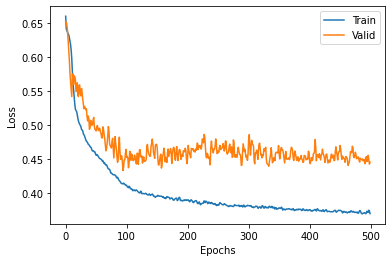

In [63]:
train_loss_list, valid_loss_list, global_steps_list = load_metrics(destination_folder + '/metrics.pt')
epoch_train = []
epoch_valid = []
epochs = []

for x in range(len(train_loss_list)):
    epoch_train.append(sum(train_loss_list[x:x+2])/len(train_loss_list[x:x+2]))
print(len(epoch_train))

for x in range(len(valid_loss_list)):
    epoch_valid.append(sum(valid_loss_list[x:x+2])/len(valid_loss_list[x:x+2]))
print(len(epoch_valid))

for x in range(500):
    epochs.append(x)
print(len(epochs))

plt.plot(epochs, epoch_train, label='Train')
plt.plot(epochs, epoch_valid, label='Valid')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig("Transformer 500 epochs.png")
plt.show() 

In [17]:
print(global_steps_list)

[25, 50, 75, 100, 125, 150, 175, 200, 225, 250, 275, 300, 325, 350, 375, 400, 425, 450, 475, 500, 525, 550, 575, 600, 625, 650, 675, 700, 725, 750, 775, 800, 825, 850, 875, 900, 925, 950, 975, 1000, 1025, 1050, 1075, 1100, 1125, 1150, 1175, 1200, 1225, 1250, 1275, 1300, 1325, 1350, 1375, 1400, 1425, 1450, 1475, 1500, 1525, 1550, 1575, 1600, 1625, 1650, 1675, 1700, 1725, 1750, 1775, 1800, 1825, 1850, 1875, 1900, 1925, 1950, 1975, 2000, 2025, 2050, 2075, 2100, 2125, 2150, 2175, 2200, 2225, 2250, 2275, 2300, 2325, 2350, 2375, 2400, 2425, 2450, 2475, 2500, 2525, 2550, 2575, 2600, 2625, 2650, 2675, 2700, 2725, 2750, 2775, 2800, 2825, 2850, 2875, 2900, 2925, 2950, 2975, 3000, 3025, 3050, 3075, 3100, 3125, 3150, 3175, 3200, 3225, 3250, 3275, 3300, 3325, 3350, 3375, 3400, 3425, 3450, 3475, 3500, 3525, 3550, 3575, 3600, 3625, 3650, 3675, 3700, 3725, 3750, 3775, 3800, 3825, 3850, 3875, 3900, 3925, 3950, 3975, 4000, 4025, 4050, 4075, 4100, 4125, 4150, 4175, 4200, 4225, 4250, 4275, 4300, 4325, 435

Model loaded from <== solo_classification_transformer_REMI_weights_unaugmented_200epochs/metrics.pt


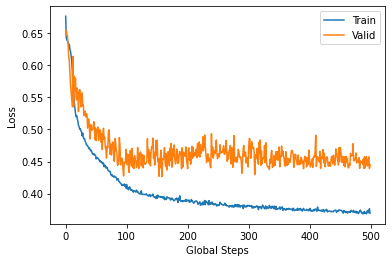

In [68]:
train_loss_list, valid_loss_list, global_steps_list = load_metrics(destination_folder + '/metrics.pt')
epochs=[]
for x in range(500):
    epochs.append(x)
plt.plot(epochs, train_loss_list, label='Train')
plt.plot(epochs, valid_loss_list, label='Valid')

plt.xlabel('Global Steps')
plt.ylabel('Loss')
plt.legend()
plt.savefig("Transformer 500 epochs.png")
plt.show() 

In [36]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

Model loaded from <== solo_classification_transformer_REMI_weights_unaugmented_200epochs/model.pt
Classification Report:
              precision    recall  f1-score   support

           1     0.7561    0.8304    0.7915       112
           0     0.9108    0.8661    0.8879       224

    accuracy                         0.8542       336
   macro avg     0.8334    0.8482    0.8397       336
weighted avg     0.8592    0.8542    0.8557       336



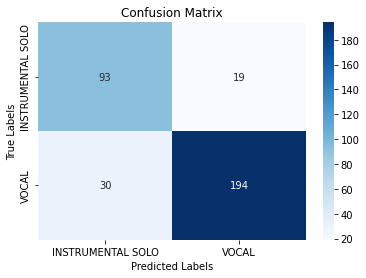

In [67]:
def evaluate(model, test_loader, version='title', threshold=0.5):
    y_pred = []
    y_true = []

    model.eval()
    with torch.no_grad():
        for (labels, (notes, notes_len)), _ in test_loader:           
            labels = labels.to(device)
            notes = notes.to(device)
            notes_len = notes_len.cpu()
            output = model(notes.long())

            output = np.argmax(output.cpu().detach(), axis=1)
            y_pred.extend(output.tolist())
            y_true.extend(labels.tolist())
    
    print('Classification Report:')
    print(classification_report(y_true, y_pred, labels=[1,0], digits=4))
    
    cm = confusion_matrix(y_true, y_pred, labels=[1,0])
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")

    ax.set_title('Confusion Matrix')

    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

    ax.xaxis.set_ticklabels(['INSTRUMENTAL SOLO', 'VOCAL'])
    ax.yaxis.set_ticklabels(['INSTRUMENTAL SOLO', 'VOCAL'])
    
    
best_model = TransformerModel(ntokens,emsize,nhead,d_hid,nlayers,dropout).to(device)
optimizer = optim.Adam(best_model.parameters(), lr=0.001)

load_checkpoint(destination_folder + '/model.pt', best_model, optimizer)
evaluate(best_model, test_iter)

In [24]:
df_intro = pd.read_csv(source_folder + '/test.csv')
melodies = df_intro['melody'].values
labels = df_intro['label'].values

In [35]:
test_instance = [x.lower() for x in melodies[0].split(' ')]
print(test_instance)

['0', '1', '2', '104', '28', '67', '73', '27', '7', '68', '43', '27', '29', '67', '73', '27', '10', '60', '43', '27', '37', '41', '43', '27', '11', '67', '43', '27', '30', '67', '73', '31', '32', '60', '43', '27', '33', '71', '73', '31', '18', '21', '43', '31', '24', '19', '42', '27', '20', '67', '43', '31', '0', '1', '19', '43', '27', '28', '21', '43', '27', '7', '16', '73', '27', '29', '67', '44', '31', '10', '66', '73', '27', '37', '67', '73', '27', '11', '71', '73', '27', '30', '67', '43', '25', '15', '16', '12', '27', '33', '41', '42', '77', '0', '29', '68', '44', '27', '10', '68', '73', '27', '37', '60', '73', '27', '11', '78', '73', '27', '30', '78', '73', '27', '32', '71', '73', '31', '33', '74', '43', '27', '18', '16', '42', '27', '24', '60', '42', '27', '20', '67', '42', '27', '0', '1', '21', '79', '27', '28', '4', '79', '27', '7', '19', '22', '27', '29', '4', '42', '25', '37', '78', '12', '31', '30', '67', '12', '89', '26', '16', '12', '27', '0', '1', '34', '42', '9', '32', 

In [33]:
tokens = [text_field.vocab.stoi[token] for token in test_instance]
print(tokens)

[4, 7, 30, 158, 20, 41, 47, 6, 18, 14, 40, 6, 25, 41, 47, 6, 11, 9, 40, 6, 34, 8, 40, 6, 19, 41, 40, 6, 26, 41, 47, 2, 36, 9, 40, 6, 37, 15, 47, 2, 16, 65, 40, 2, 42, 53, 23, 6, 28, 41, 40, 2, 4, 7, 53, 40, 6, 20, 65, 40, 6, 18, 12, 47, 6, 25, 41, 60, 2, 11, 17, 47, 6, 34, 41, 47, 6, 19, 15, 47, 6, 26, 41, 40, 5, 21, 12, 27, 6, 37, 8, 23, 69, 4, 25, 14, 60, 6, 11, 14, 47, 6, 34, 9, 47, 6, 19, 32, 47, 6, 26, 32, 47, 6, 36, 15, 47, 2, 37, 59, 40, 6, 16, 12, 23, 6, 42, 9, 23, 6, 28, 41, 23, 6, 4, 7, 65, 38, 6, 20, 24, 38, 6, 18, 53, 44, 6, 25, 24, 23, 5, 34, 32, 27, 2, 26, 41, 27, 84, 33, 12, 27, 6, 4, 7, 10, 23, 45, 36, 24, 38, 5, 21, 9, 44, 103]


In [50]:
tensor_tokens = torch.LongTensor(tokens).unsqueeze(1).to(device)
outputs = model(tensor_tokens)
attention = outputs
print(attention)

tensor([[1.7095e-23, 1.0000e+00],
        [1.0000e+00, 3.1082e-20],
        [1.0000e+00, 1.5642e-24],
        [4.9197e-25, 1.0000e+00],
        [3.2338e-24, 1.0000e+00],
        [8.6531e-26, 1.0000e+00],
        [9.0611e-24, 1.0000e+00],
        [1.0000e+00, 4.7799e-22],
        [2.2345e-25, 1.0000e+00],
        [1.9060e-25, 1.0000e+00],
        [1.0000e+00, 1.0706e-19],
        [1.0000e+00, 6.4574e-22],
        [2.6405e-23, 1.0000e+00],
        [8.8408e-25, 1.0000e+00],
        [1.0000e+00, 1.4071e-19],
        [1.0000e+00, 6.3143e-22],
        [1.0000e+00, 2.6471e-23],
        [8.5144e-25, 1.0000e+00],
        [1.0000e+00, 8.6398e-19],
        [1.0000e+00, 1.9478e-24],
        [4.3017e-24, 1.0000e+00],
        [8.6894e-22, 1.0000e+00],
        [6.1413e-16, 1.0000e+00],
        [1.0000e+00, 4.7866e-24],
        [7.0811e-25, 1.0000e+00],
        [3.9402e-23, 1.0000e+00],
        [5.7394e-25, 1.0000e+00],
        [1.0000e+00, 1.1796e-21],
        [6.6878e-16, 1.0000e+00],
        [7.806

In [51]:
from bertviz import model_view, head_view

model_view(attention, tokens)

IndexError: dimension specified as 0 but tensor has no dimensions